# IV. Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df_residential = pd.read_csv('../Data/DF_Residential_v10.csv')
pd.set_option('max_columns',100)
df_residential.head()

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,EYB,PRICE,QUALIFIED,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,ZIPCODE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,CENSUS_TRACT,WARD,SQUARE,QUADRANT,SALEYEAR,ayb_age,eyb_age
0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1972,1095000.0,Q,2522.0,1,3 Story,1,4,1,Common Brick,1,Hardwood,2.0,5,24,1680,20009.0,38.914680,-77.040832,Old City 2,4201.0,Ward 2,152,NW,2003,108.0,46
1,3,1,Hot Water Rad,Y,2.0,9,3,1908.0,1969,592250.0,Q,1598.0,1,2 Story,1,3,1,Common Brick,0,Hardwood,2.0,1,24,1424,20009.0,38.915019,-77.040138,Old City 2,4201.0,Ward 2,152,NW,2001,110.0,49
2,3,1,Hot Water Rad,Y,1.0,14,5,1880.0,1987,33232.0,U,3465.0,1,3 Story,0,4,1,Common Brick,0,Hardwood,1.0,3,13,2090,20009.0,38.911370,-77.033774,Old City 2,5201.0,Ward 2,208,NW,2016,138.0,31
3,1,0,Forced Air,Y,1.0,6,3,1880.0,1967,907400.0,Q,1790.0,1,2 Story,0,2,1,Common Brick,0,Hardwood,1.0,0,13,2090,20009.0,38.911368,-77.033925,Old City 2,5201.0,Ward 2,208,NW,2006,138.0,51
4,2,1,Forced Air,Y,1.0,5,3,1880.0,1984,1065000.0,Q,1600.0,1,2 Story,0,2,1,Common Brick,0,Hardwood,1.0,1,13,2090,20009.0,38.911368,-77.033972,Old City 2,5201.0,Ward 2,208,NW,2012,138.0,34


In [3]:
df_residential.shape

(53737, 35)

In [4]:
df_residential.columns

Index(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM',
       'AYB', 'EYB', 'PRICE', 'QUALIFIED', 'GBA', 'BLDG_NUM', 'STYLE',
       'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS',
       'FIREPLACES', 'USECODE', 'LANDAREA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'CENSUS_TRACT', 'WARD', 'SQUARE', 'QUADRANT',
       'SALEYEAR', 'ayb_age', 'eyb_age'],
      dtype='object')

## Model Training

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, PoissonRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor

In [6]:
# Dictionary to keep the assessment of each model
model_assessment = []

# Funtion to assess the model performance
def assess_model(model, model_key, poly=False):
    if poly==True:
        dataset = [[X_train_pr, y_train, 'Training'], [X_val_pr, y_val, 'Validation']]
    else:
        dataset = [[X_train_prepared, y_train, 'Training'], [X_val_prepared, y_val, 'Validation']]
    
    for data in dataset:
        y_pred = model.predict(data[0])
        
        model_assessment.append([model_key,
                               data[2],
                               mean_squared_error(data[1], y_pred),
                               np.sqrt(mean_squared_error(data[1], y_pred)),
                               mean_absolute_error(data[1], y_pred),
                               r2_score(data[1], y_pred)])
        
        print(data[2])
        print('MSE: {}'.format(mean_squared_error(data[1], y_pred)))
        print('RMSE: {}'.format(np.sqrt(mean_squared_error(data[1], y_pred))))
        print('MAE: {}'.format(mean_absolute_error(data[1], y_pred)))
        print('R-squared: {}'.format(r2_score(data[1], y_pred)))
        print('\n')

### 1. Linear Regression

In [7]:
# Splitting Training, Validation, Testing Set
num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM', 'GBA', 'ayb_age', 'eyb_age', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'NUM_UNITS', 'LATITUDE', 'LONGITUDE']
onehot_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE', 'ASSESSMENT_NBHD']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR', 'EXTWALL', 'INTWALL']
label = ['PRICE']

from sklearn.model_selection import train_test_split

X = df_residential[num_cols + onehot_cols + ordinal_cols]
y = df_residential['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols)
])

X_train_prepared = col_transformer.fit_transform(X_train)
X_val_prepared = col_transformer.transform(X_val)
X_test_prepared = col_transformer.transform(X_test)

In [8]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [9]:
assess_model(lin_reg, 'Linear Regression')

Training
MSE: 19645861311.51784
RMSE: 140163.69469844122
MAE: 105799.10188238345
R-squared: 0.7999913128298564


Validation
MSE: 19031124475.4135
RMSE: 137953.34166091628
MAE: 103854.49297133215
R-squared: 0.8055673770004458




In the Multiple Linear Regression model, we get an underfitting result, so we will try to increase the model's complexity with Polynomial Regression. We do not try using Ridge/Lasso to improve the result of this model as performing Ridge/Lasso will not improve the model significantly because of the underfitting result and there is no multicollinearity in our data.

### 2. Polynomial Regression

In [10]:
# Select different features for polynomial
num_cols_pr = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES']
onehot_cols_pr = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT']
ordinal_cols_pr = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label_pr = ['PRICE']

X_pr = df_residential[num_cols_pr + onehot_cols_pr + ordinal_cols_pr]
y_pr = df_residential['PRICE']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pr, y_pr, test_size=0.3, random_state=22)
X_test_p, X_val_p, y_test_p, y_val_p = train_test_split(X_test_p, y_test_p, test_size=0.5, random_state=22)

col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols_pr),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols_pr),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols_pr)
])

X_train_prepared_pr = col_transformer.fit_transform(X_train_p)
X_val_prepared_pr = col_transformer.transform(X_val_p)
X_test_prepared_pr = col_transformer.transform(X_test_p)

In [11]:
pr = PolynomialFeatures(degree=2, include_bias=False)

X_train_pr = pr.fit_transform(X_train_prepared_pr)
X_val_pr = pr.transform(X_val_prepared_pr)
X_test_pr = pr.transform(X_test_prepared_pr)

In [12]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_pr, y_train_p)

LinearRegression()

In [13]:
assess_model(lin_reg, 'Polynomial Regression', poly=True)

Training
MSE: 13906696118.129547
RMSE: 117926.65567262369
MAE: 85250.78490229126
R-squared: 0.8584200514624152


Validation
MSE: 13852909398.79936
RMSE: 117698.38316136446
MAE: 85586.61474733171
R-squared: 0.8584709214600829




After we try to increase the model's complexity with Polynomial Regression and reduce the features, we get a better result. Since the result does not overfit, we will not try to regularize it with Ridge/Lasso.

### 3. Decision Tree Regressor

In [14]:
# Splitting Training, Validation, Testing Set
num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'LATITUDE', 'LONGITUDE']
onehot_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label = ['PRICE']

X = df_residential[num_cols + onehot_cols + ordinal_cols]
y = df_residential['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols)
])

X_train_prepared = col_transformer.fit_transform(X_train)
X_val_prepared = col_transformer.transform(X_val)
X_test_prepared = col_transformer.transform(X_test)

In [15]:
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train_prepared, y_train)
dt.score(X_train_prepared, y_train)

0.9999999482793699

In [16]:
assess_model(dt, 'Decision Tree Regressor')

Training
MSE: 5080.260959723514
RMSE: 71.2759493779179
MAE: 1.060587531569854
R-squared: 0.9999999482793699


Validation
MSE: 19460542657.864437
RMSE: 139501.04894897543
MAE: 90685.02985568374
R-squared: 0.8011802004210744




Since decision tree gives an overfit model, we try random forest to address this issue and to reduce the variance. Random forest will split the training data into multiple samples with replacement (bootstrap sample) and then makes a tree for each bootstrap sample with feature randomization. The majority vote will be the final result.

### 4. Random Forest

In [17]:
rf = RandomForestRegressor(random_state=22)
rf.fit(X_train_prepared, y_train)

RandomForestRegressor(random_state=22)

In [18]:
assess_model(rf, 'Random Forest Regressor')

Training
MSE: 1362925494.1739726
RMSE: 36917.820821034016
MAE: 23577.84752640643
R-squared: 0.9861244597791883


Validation
MSE: 9184055656.095436
RMSE: 95833.47878531508
MAE: 62224.82474005549
R-squared: 0.9061705453455751




### 4.1 Random Forest - Tuned

In [19]:
rf = RandomForestRegressor(min_samples_leaf=9, random_state=22)
rf.fit(X_train_prepared, y_train)

RandomForestRegressor(min_samples_leaf=9, random_state=22)

In [20]:
assess_model(rf, 'Random Forest Regressor - Tuned')

Training
MSE: 6379519830.009168
RMSE: 79871.89637168488
MAE: 51589.82673902104
R-squared: 0.9350520007372763


Validation
MSE: 9609771150.337467
RMSE: 98029.44022250391
MAE: 64903.55644271399
R-squared: 0.9018211975020483




### 5. Voting Regressor

In [21]:
from sklearn.ensemble import VotingRegressor

In [22]:
ridge = Ridge()

In [23]:
estimators = [
    ('lin_reg', lin_reg),
    ('ridge', ridge),
    ('dt', dt),
    #('bay_ridge', bay_ridge),
    ('rf', rf),
    #('lasso', lasso),
    #('poly', poly),
    #('svr', svr)
]

In [24]:
np.random.seed(22)
voting_reg = VotingRegressor(
    estimators=estimators
)

voting_reg.fit(X_train_prepared, y_train.ravel())

VotingRegressor(estimators=[('lin_reg', LinearRegression()), ('ridge', Ridge()),
                            ('dt', DecisionTreeRegressor(random_state=0)),
                            ('rf',
                             RandomForestRegressor(min_samples_leaf=9,
                                                   random_state=22))])

In [25]:
assess_model(voting_reg, 'Voting Regressor')

Training
MSE: 7503408623.100984
RMSE: 86622.21783757897
MAE: 63729.06870104872
R-squared: 0.9236100222733571


Validation
MSE: 12375408885.699139
RMSE: 111244.81509580182
MAE: 79820.6096693258
R-squared: 0.8735658939414197




### 6. CatBoost Regressor (Final Model)

In [26]:
# Splitting Training, Validation, Testing Set
num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'LATITUDE', 'LONGITUDE']
onehot_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label = ['PRICE']

X = df_residential[num_cols + onehot_cols + ordinal_cols]
y = df_residential['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

# Scaling & Encoding
col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols)
])

X_train_prepared = col_transformer.fit_transform(X_train)
X_val_prepared = col_transformer.transform(X_val)
X_test_prepared = col_transformer.transform(X_test)

In [27]:
catboost = CatBoostRegressor(verbose=False)
catboost.fit(X_train_prepared, y_train)

In [28]:
assess_model(catboost, 'CatBoost Regressor')

Training
MSE: 5917662506.891661
RMSE: 76926.34468692543
MAE: 52081.82933338932
R-squared: 0.9397540331598758


Validation
MSE: 7853914475.620474
RMSE: 88622.313644028
MAE: 57806.674921628415
R-squared: 0.9197600123796217




### Model Assessment

In [29]:
# Store all assessment results in a dataframe
df_model_result = pd.DataFrame(data=model_assessment, columns=['Model', 'Set', 'MSE', 'RMSE', 'MAE', 'R2'])
df_model_result

,Model,Set,MSE,RMSE,MAE,R2
0,Linear Regression,Training,1.964586e+10,140163.694698,105799.101882,0.799991
1,Linear Regression,Validation,1.903112e+10,137953.341661,103854.492971,0.805567
2,Polynomial Regression,Training,1.390670e+10,117926.655673,85250.784902,0.858420
3,Polynomial Regression,Validation,1.385291e+10,117698.383161,85586.614747,0.858471
4,Decision Tree Regressor,Training,5.080261e+03,71.275949,1.060588,1.000000
5,Decision Tree Regressor,Validation,1.946054e+10,139501.048949,90685.029856,0.801180
6,Random Forest Regressor,Training,1.362925e+09,36917.820821,23577.847526,0.986124
7,Random Forest Regressor,Validation,9.184056e+09,95833.478785,62224.824740,0.906171
8,Random Forest Regressor - Tuned,Training,6.379520e+09,79871.896372,51589.826739,0.935052
9,Random Forest Regressor - Tuned,Validation,9.609771e+09,98029.440223,64903.556443,0.901821


In [30]:
df_model_result[(df_model_result['Set'] == 'Validation')]

,Model,Set,MSE,RMSE,MAE,R2
1,Linear Regression,Validation,1.903112e+10,137953.341661,103854.492971,0.805567
3,Polynomial Regression,Validation,1.385291e+10,117698.383161,85586.614747,0.858471
5,Decision Tree Regressor,Validation,1.946054e+10,139501.048949,90685.029856,0.801180
7,Random Forest Regressor,Validation,9.184056e+09,95833.478785,62224.824740,0.906171
9,Random Forest Regressor - Tuned,Validation,9.609771e+09,98029.440223,64903.556443,0.901821
11,Voting Regressor,Validation,1.237541e+10,111244.815096,79820.609669,0.873566
13,CatBoost Regressor,Validation,7.853914e+09,88622.313644,57806.674922,0.919760


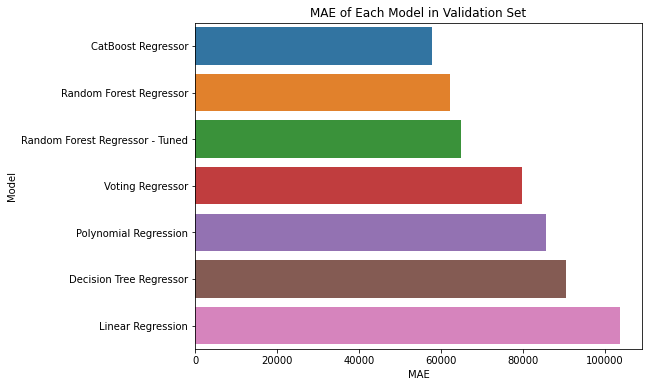

In [31]:
fig = plt.figure(figsize=(8, 6))
sns.barplot(data=df_model_result[(df_model_result['Set'] == 'Validation')].sort_values(by='MAE'),
            x='MAE', y='Model')
plt.title('MAE of Each Model in Validation Set')
plt.savefig('../Model/Model.png', bbox_inches = 'tight')
plt.show()

### Cross Validation

In [32]:
scores_train = cross_val_score(catboost, X_train_prepared, y_train, cv=5, scoring='r2')
print('Training Cross Validation Scores')
print('Mean :', scores_train.mean())
print('Std :', scores_train.std())

Training Cross Validation Scores
Mean : 0.9143099776630802
Std : 0.003728108709288563


### Hyperparameter Tuning for CatBoost Regressor

In [35]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Final Model

We use Categorical Booster Regressor as our final model as it gives the best R$^2$ results in both training and validation set and the lowest MAE compared with other models.

### Merge Training Set with Validation Set

In [36]:
# Export df_train and df_test for final model
df_train_1 = pd.concat([X_train, y_train], axis=1)
df_train_2 = pd.concat([X_val, y_val], axis=1)
df_train = pd.concat([df_train_1, df_train_2], axis=0)

df_test = pd.concat([X_test, y_test], axis=1)

In [37]:
# Export clean df_train to csv
df_train.to_csv('../Data/DF_Train.csv', index=False)

In [38]:
# Export clean df_test to csv
df_test.to_csv('../Data/DF_Test.csv', index=False)

### Re-train Model

In [39]:
# Load the dataset
df_train = pd.read_csv('../Data/DF_Train.csv')

num_cols = ['BATHRM', 'HF_BATHRM', 'ROOMS', 'BEDRM','ayb_age', 'eyb_age', 'GBA', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'LATITUDE', 'LONGITUDE']
onehot_cols = ['AC', 'QUALIFIED', 'WARD', 'QUADRANT', 'HEAT', 'STYLE', 'USECODE']
ordinal_cols = ['STRUCT', 'GRADE', 'CNDTN', 'ROOF', 'SALEYEAR']
label = ['PRICE']

# Data Pre-processing
X_train = df_train[num_cols + onehot_cols + ordinal_cols]
y_train = df_train['PRICE']

col_transformer = ColumnTransformer([
    ('robust_scaler', RobustScaler(), num_cols),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), ordinal_cols)
])

full_pipeline = Pipeline([('col_transformer', col_transformer),
                          ('catboost', CatBoostRegressor(verbose=False))])

# Re-train the model
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['BATHRM', 'HF_BATHRM',
                                                   'ROOMS', 'BEDRM', 'ayb_age',
                                                   'eyb_age', 'GBA', 'KITCHENS',
                                                   'FIREPLACES', 'LANDAREA',
                                                   'LATITUDE', 'LONGITUDE']),
                                                 ('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['AC', 'QUALIFIED', 'WARD',
                                                   'QUADRANT', 'HEAT', 'STYLE',
                                                   'USECODE']),
                                                 ('ordinal_en

In [40]:
y_pred = full_pipeline.predict(X_train)
print('MSE: {}'.format(mean_squared_error(y_train, y_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_train, y_pred)))
print('R-squared: {}'.format(r2_score(y_train, y_pred)))
print('\n')

MSE: 6045042175.841646
RMSE: 77749.86929790716
MAE: 52397.90759865191
R-squared: 0.9384193408023569




### Target Metrics Evaluation

In [41]:
price_med = df_residential['PRICE'].median()
des_mae = 0.13 * price_med

print('Price median : {}\nDesired MAE (13% * median) : {}\nAchieved MAE : {}'.format(price_med, des_mae, mean_absolute_error(y_train, y_pred)))

Price median : 410000.0
Desired MAE (13% * median) : 53300.0
Achieved MAE : 52397.90759865191


<b> From the result shown above, we have achieved the desired MAE metrics value of under 53300. <b/>

C:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


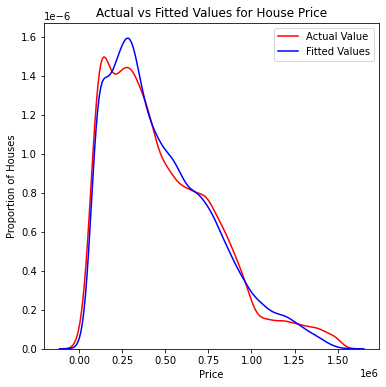

In [42]:
# Distribution plot
plt.figure(figsize=(6, 6))

ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for House Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Houses')

plt.legend()
plt.show()
plt.close()

In [43]:
df_results = pd.DataFrame({
    'Actual': y_train.tolist(),
    'Prediction': y_pred.tolist()
})

df_results['Error'] = df_results['Prediction'] - df_results['Actual']
df_results

,Actual,Prediction,Error
0,210000.0,184426.314020,-25573.685980
1,250000.0,298358.365216,48358.365216
2,685000.0,739835.383150,54835.383150
3,798500.0,810131.528879,11631.528879
4,350000.0,343594.530965,-6405.469035
...,...,...,...
45671,250000.0,225789.001543,-24210.998457
45672,500000.0,551605.204401,51605.204401
45673,505000.0,563453.235955,58453.235955
45674,585000.0,483005.396874,-101994.603126


In [44]:
df_results[['Error']].describe()

,Error
count,45676.000000
mean,2.593740
std,77750.720371
min,-792397.729279
25%,-35156.931848
50%,-745.915213
75%,34811.718417
max,839104.467081


C:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


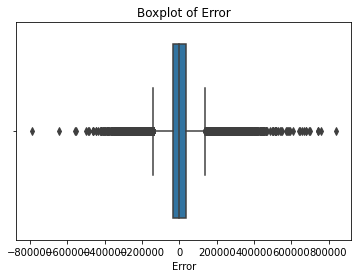

In [45]:
sns.boxplot(df_results['Error'])
plt.title("Boxplot of Error")
plt.show()

C:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


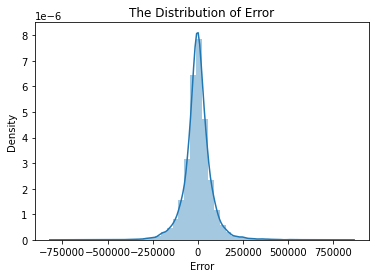

In [46]:
sns.distplot(df_results['Error'])
plt.title("The Distribution of Error")
plt.show()

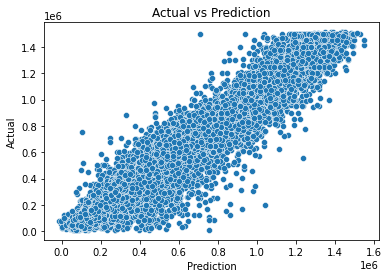

In [47]:
# Residual Analysis
sns.scatterplot(x='Prediction', y='Actual', data=df_results)
plt.title("Actual vs Prediction")
plt.show()

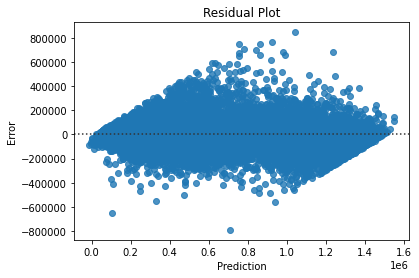

In [48]:
# Residual plot
sns.residplot(x='Prediction', y='Error', data=df_results)
plt.title("Residual Plot")
plt.show()

From the analysis results above, we can see that there are many outliers in residuals, so we decide to use MAE as our standard error instead of RMSE as RMSE is very sensitive to outliers. 

In [49]:
scores_train = cross_val_score(full_pipeline, X_train, y_train, cv=5, scoring='r2', error_score="raise")
print('Training Cross Validation Scores')
print('Mean :', scores_train.mean())
print('Std :', scores_train.std())

Training Cross Validation Scores
Mean : 0.915929938236608
Std : 0.003276957338922221


### Evaluate Model

In [50]:
df_test = pd.read_csv('../Data/DF_Test.csv')

X_test = df_test.drop('PRICE', axis=1)
y_test = df_test['PRICE']

y_pred = full_pipeline.predict(X_test)
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(r2_score(y_test, y_pred)))
print('\n')

MSE: 7337746604.308391
RMSE: 85660.64793304093
MAE: 56521.79324314138
R-squared: 0.9246479046609484




C:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


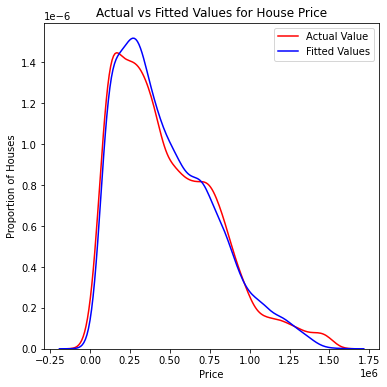

In [51]:
# Distribution plot
plt.figure(figsize=(6, 6))

ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for House Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Houses')
plt.legend()
plt.show()
plt.close()

### Save Model

In [53]:
import pickle
import warnings
warnings.filterwarnings('ignore')

# Pickle the model
pickle_filename = '../Model/Final_Model_Catboost.sav'
pickle.dump(full_pipeline, open(pickle_filename, 'wb'))